In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, r'C:\Users\Roma\OneDrive\Projects\VNC\profile')
sys.path.insert(0, r'C:\Users\Roma\Projects\aux-source')
from plasma_scenario import *
from aux_source import ptrac

In [2]:
data = np.loadtxt('trt.txt', delimiter='\t') * 100

In [23]:
fitter = Fitter(a_max = 60, shift_max=10, triang_max=0.2, ellip_max=1.9, R0 = x0+10, Z0=y0)

In [24]:
scenario = fitter.fit(data[:, 0].reshape(1, -1), data[:, 1].reshape(1, -1), np.array([50]), np.linspace(0, 2 * np.pi, 100))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0972865282629994
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14237437955669066
            Iterations: 11
            Function evaluations: 44
            Gradient evaluations: 11


In [25]:
scenario = ParametricMagneticSurface(theta=0, shift0=5, shift_slope=0, triang_x=30, triang_y=0.05, ellip0=1, ellipx=30,
                                    ellipy=1.1, shift_max=10, triang_max=0.2, ellip_max=1.9, a_max=60, R0=x0+5, Z0=y0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


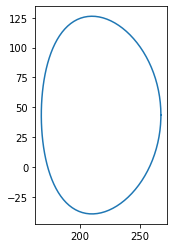

In [26]:
xx, yy = scenario.rz_eval(50, phi)
plt.plot(xx, yy)
plt.axes().set_aspect('equal')

In [27]:
x0, y0

(211.02486999999996, 43.576063345)

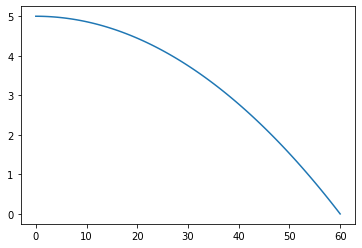

In [28]:
a = np.linspace(0, 60, 100)
sh = scenario.shift_eval(a)
plt.plot(a, sh)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


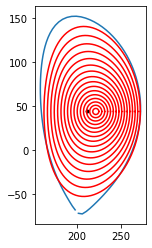

In [29]:
x0, y0 = np.mean(data, axis=0)
plt.plot(data[:, 0], data[:, 1])
a_max, b_max = np.max(data, axis=0) - np.min(data, axis=0)
plt.plot(x0, y0, 'k.')
Nphi = 200
phi = np.linspace(0, 2 * np.pi, Nphi)
d = b_max / a_max - 1
npts = 1000
minor_pts = np.zeros(npts)

Nx = 25
Ny = 50
x_bins = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), Nx + 1) 
y_bins = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), Ny + 1)
x_mid = 0.5 * (x_bins[1:] + x_bins[:-1])
y_mid = 0.5 * (y_bins[1:] + y_bins[:-1])
intensity = np.zeros((Nx, Ny))
dx = np.mean(np.diff(x_bins))
dy = np.mean(np.diff(y_bins))
tol = np.sqrt(dx**2 + dy**2) / 100

x = np.zeros((npts, phi.size))
y = np.zeros((npts, phi.size))

for i, k in enumerate(np.linspace(0, 1, npts)):
    a = a_max * k / 2
    minor_pts[i] = a
    b = (b_max - (1 - k) * d * a_max) * k / 2
    xx, yy = scenario.rz_eval(a, phi)
    x[i, :] = xx #x0 + a * np.cos(phi) + 5
    y[i, :] = yy #y0 + b * np.sin(phi)
    #print(a)
    if i % 60 == 0:
        xx, yy = scenario.rz_eval(a, phi)
        plt.plot(xx, yy, 'r')
plt.axes().set_aspect('equal')

for i in range(Nx):
    print(i)
    for j in range(Ny):
        distance = np.sqrt((x - x_mid[i])**2 + (y - y_mid[j])**2)
        ind = np.argmin(distance) // Nphi
        #print(ind)
        intensity[i, j] = 1 / np.sqrt(2 * np.pi * sig**2) * np.exp(-0.5 * (minor_pts[ind] / sig)**2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


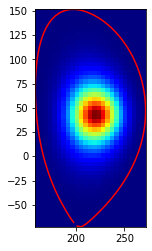

In [30]:
plt.pcolor(x_bins, y_bins, intensity.transpose(), cmap='jet')
plt.plot(data[:, 0], data[:, 1], 'r')
plt.axes().set_aspect('equal')

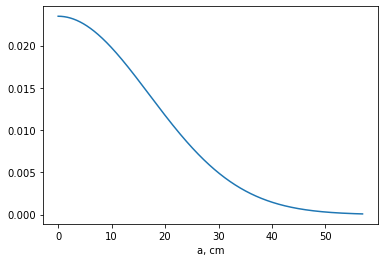

In [31]:
sig = 17
intensity_pts = 1 / np.sqrt(2 * np.pi * sig**2) * np.exp(-0.5 * (minor_pts / sig)**2)
plt.plot(minor_pts, intensity_pts)
plt.xlabel('a, cm')
plt.savefig('trt_profile.png', dpi=600)

In [32]:
from mckit import source

In [33]:
def create_bin_distributions(bins, start_name):
    """Creates individual distributions for every bin.

    Parameters
    ----------
    bins : array_like 
        Bin boundaries.
    start_name : int
        Starting name of the distributions.

    Returns
    -------
    free_name : int
        Distribution name, that can be used for new distributions.
    distributions : list
        A list of created distributions.
    """
    distributions = []
    for i in range(len(bins) - 1):
        distributions.append(
            source.Distribution(start_name, bins[i:i+2], [1])
        )
        start_name += 1
    return start_name, distributions

In [34]:
start_name=1
aux_name = start_name + 10
aux_name, x_distr = create_bin_distributions(x_bins, aux_name)
# ybins
aux_name, y_distr = create_bin_distributions(y_bins, aux_name)
probs = []
r_indices = []
z_indices = []
for i in range(Nx):
    for j in range(Ny):
        if intensity[i, j] > 0:
            r_indices.append(x_distr[i])
            z_indices.append(y_distr[j])
            probs.append(intensity[i, j])
r_dist = source.Distribution(start_name + 1, r_indices, probs, 'RAD')
z_dist = source.Distribution(start_name + 2, z_indices, r_dist, 'EXT')
src = source.Source(RAD=r_dist, EXT=z_dist)

In [35]:
print(src.mcnp_repr())

SDEF RAD=D2 EXT=FRAD D3
SI2 S 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
        11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 
        11 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 
        12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 
        12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 
        13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 
        13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 
        14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 
        14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 
        15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 
        15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 
        16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 
    

In [36]:
datap = ptrac.read_ptrac('src_test.p')
pos = np.zeros((len(datap), 3))
for i, p in enumerate(datap):
    pos[i, :] = p.position

In [37]:
rad = np.linalg.norm(pos[:, :2], axis=1)
ext = pos[:, 2]
index_x = np.searchsorted(x_bins, rad) - 1
index_y = np.searchsorted(y_bins, ext) - 1
probs = np.zeros_like(intensity)
out_num = 0
for i, j in zip(index_x, index_y):
    if i < x_bins.size - 1 and j < y_bins.size - 1:
        probs[i, j] += 1
    else:
        out_num += 1
print(out_num)


7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


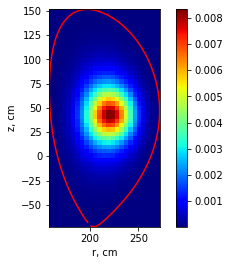

In [18]:
plt.pcolor(x_bins, y_bins, probs.transpose() / np.sum(probs), cmap='jet')
plt.plot(data[:, 0], data[:, 1], 'r')
plt.axes().set_aspect('equal')
plt.colorbar()
plt.xlabel('r, cm')
plt.ylabel('z, cm')
plt.savefig('trt_source.png', dpi=600)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


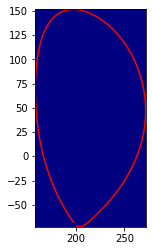

In [19]:
plt.pcolor(x_bins, y_bins, intensity.transpose(), cmap='jet')
plt.plot(data[:, 0], data[:, 1], 'r')
plt.axes().set_aspect('equal')

In [20]:
distrs = source.expand_matrix_distribution(intensity, x_bins, y_bins)

ValueError: too many values to unpack (expected 2)

In [ ]:
data2 = np.random.permutation(data)

In [ ]:
plt.plot(data2[:, 0], data2[:, 1])
plt.plot(data2[:, 0], data2[:, 1], 'r.')
plt.axes().set_aspect('equal')

In [ ]:
def get_right_order(x):
    N = x.shape[0] 
    mid_point = np.mean(x, axis=0)
    deltas = x - mid_point
    phi = np.arctan2(deltas[:, 0], deltas[:, 1])
    indices = np.argsort(phi)
    data = np.zeros_like(x)
    data[:, 0] = x[indices, 0]
    data[:, 1] = x[indices, 1]
    return data

In [ ]:
data3 = get_right_order(data2)

In [ ]:
plt.plot(data3[:, 0], data3[:, 1], 'r.')
plt.plot(data3[:, 0], data3[:, 1], 'k')
plt.axes().set_aspect('equal')